In [1]:
# %%
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat

In [2]:
df=pd.read_csv('C:/workspace_python/study/data_plus/2s/15day_0201_0215.csv')
df['new_Date']=pd.to_datetime(df['ds'])
df.head()


,Unnamed: 0,ds,y,new_Date
0,0,2021-02-01 19:00:00,12.0,2021-02-01 19:00:00
1,1,2021-02-01 19:00:02,7.0,2021-02-01 19:00:02
2,2,2021-02-01 19:00:04,1.0,2021-02-01 19:00:04
3,3,2021-02-01 19:00:06,16.0,2021-02-01 19:00:06
4,4,2021-02-01 19:00:08,19.0,2021-02-01 19:00:08


In [3]:
New=df[['y']]  #시간과 real_free 만 뽑아서 새로운 데이터 프레임
New.index=df['new_Date']
New.head()

,y
new_Date,
2021-02-01 19:00:00,12.0
2021-02-01 19:00:02,7.0
2021-02-01 19:00:04,1.0
2021-02-01 19:00:06,16.0
2021-02-01 19:00:08,19.0


In [4]:
min=New.resample('1T').first()
print(min)


                        y
new_Date                 
2021-02-01 19:00:00  12.0
2021-02-01 19:01:00   3.0
2021-02-01 19:02:00   1.0
2021-02-01 19:03:00   0.0
2021-02-01 19:04:00   0.0
...                   ...
2021-02-16 18:55:00   0.0
2021-02-16 18:56:00   1.0
2021-02-16 18:57:00   5.0
2021-02-16 18:58:00  19.0
2021-02-16 18:59:00  19.0

[21600 rows x 1 columns]


In [5]:
#스케일링 하는 함수 생성
def series_to_superised(data,n_in=1,n_out=1,dropnan=True):
    n_vars=1 if type(data) is list else data.shape[1]
    df=pd.DataFrame(data)
    cols,names=list(),list()
  
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names +=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]

    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i==0:
            names+=[('var%d(t)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)'%(j+1,i)) for j in range(n_vars)]
  
    agg=concat(cols,axis=1)
    agg.columns=names

    if dropnan:
        agg.dropna(inplace=True)
  
    return agg

In [6]:
#주어진 데이터 정규화, 스케일링
values = globals()['min'].values
values_1 = values.reshape(-1,1)

#minmax scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values_1)

#250개의 이전 데이터로 120개의 데이터 예측->2시간치 데이터 예측
a=250
b=120

reframed = series_to_superised(scaled, a, b)
values_2 = reframed.values

In [7]:
#train 데이터, test 데이터 분리
n_train_days = int(values_2.shape[0] * 0.9)
train = values_2[:n_train_days, :]
test = values_2[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-b], train[:, -b:]
test_X, test_y = test[:, :-b], test[:, -b:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(19107, 1, 250) (19107, 120) (2124, 1, 250) (2124, 120)


In [8]:
#lstm 모델 생성
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(128,return_sequences=False))
model.add(Dense(b))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)



Epoch 1/10
299/299 [==============================] - 27s 37ms/step - loss: 0.1271 - val_loss: 0.1332
Epoch 2/10
299/299 [==============================] - 4s 13ms/step - loss: 0.1194 - val_loss: 0.1296
Epoch 3/10
299/299 [==============================] - 5s 17ms/step - loss: 0.1182 - val_loss: 0.1274
Epoch 4/10
299/299 [==============================] - 6s 22ms/step - loss: 0.1173 - val_loss: 0.1265
Epoch 5/10
299/299 [==============================] - 6s 20ms/step - loss: 0.1166 - val_loss: 0.1257
Epoch 6/10
299/299 [==============================] - 6s 21ms/step - loss: 0.1159 - val_loss: 0.1252
Epoch 7/10
299/299 [==============================] - 6s 21ms/step - loss: 0.1153 - val_loss: 0.1249
Epoch 8/10
299/299 [==============================] - 5s 16ms/step - loss: 0.1148 - val_loss: 0.1247
Epoch 9/10
299/299 [==============================] - 5s 15ms/step - loss: 0.1143 - val_loss: 0.1245
Epoch 10/10
299/299 [==============================] - 5s 16ms/step - loss: 0.1140 - val_l

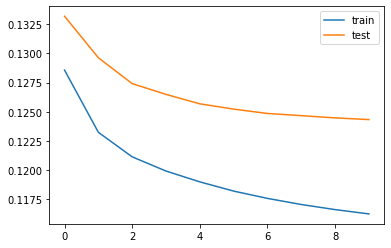

In [9]:
# plot history 그리기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
#test_X 부분을 예측모델을 통해 예측
yhat=model.predict(test_X)

In [11]:
#test 부분 예측 값 중복 제거하여 정리
y_hat=[]
test_yf=[]
k=len(test_X)//120
for i in range(0,k):
    yhat3 = np.array(yhat[i*120]).flatten().tolist()
    y_hat=y_hat+yhat3
    test_y2=np.array(test_y[i*120]).flatten().tolist()
    test_yf=test_yf+test_y2

In [12]:
yhat2=yhat.flatten().tolist()
y_hat_f=y_hat+yhat2[-84:]
test_y5=test_y.flatten().tolist()
test_y_f=test_yf+test_y5[-84:]


In [13]:
#y_hat_f, test_y_f 를 inverse 하여 원래의 값 도출하여 rmse 구함
y_hat_f_i=np.array(y_hat_f).reshape(1,-1)
test_y_f_i=np.array(test_y_f).reshape(1,-1)
yhat_inver=scaler.inverse_transform(y_hat_f_i)
test_y_inver=scaler.inverse_transform(test_y_f_i)

rmse=np.sqrt(np.mean(yhat_inver-test_y_inver)**2)
print('RMSE: '+str(rmse))



RMSE: 4.137315123425911


In [14]:
#최근 데이터 300개 가져와서 정규화
last_100_10min=New.values
last_250_scaled=scaler.transform(New[-250:].values)

#과거 300일치 데이터 붙여줌
X_test=[]
X_test.append(last_250_scaled)
X_test=np.array(X_test)

#모델 돌리기위해 reshape
X_test=np.reshape(X_test,(1,1,test_X.shape[2]))

#주어진 전체 데이터 이후의 1일치(144개 데이터) 예측하기
pred_price=model.predict(X_test)
pred_price=scaler.inverse_transform(pred_price)

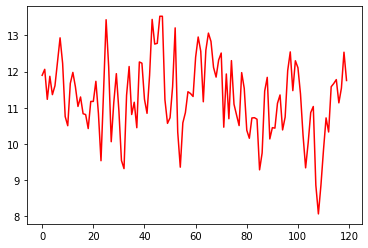

In [15]:
#구한 미래 데이터로 그래프 그려보기
from matplotlib import pyplot as plt

#그래프 그리기위해 리스트로 변경
pred_price2=pred_price.flatten().tolist()

df_list=pd.DataFrame(pred_price2,columns=['y'])
plt.plot(df_list,color='r')


In [16]:
#예측한 값 csv 파일로 뽑기

ka=pd.DataFrame(pred_price2,columns=['value'])
ka.to_csv("2hours_pred_result.csv")
